### Installing libraries which dont come bundled with jupyter notebook

In [1252]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1253]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


### Please note even after the installation you may need to restart the kernel

# Importing Libraries/Dataset

In [1254]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from time import time
from IPython.display import Markdown as md
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD

from skimage.transform import rotate, AffineTransform, warp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### Checking GPU availability

In [1255]:
is_gpu_available = tf.test.is_gpu_available()
is_gpu_available

False

In [1256]:
path_to_dataset = os.path.join(os.getcwd(), "dataset", "animals")
for dirname, _, filenames in os.walk(path_to_dataset):
    print(dirname)

C:\Users\kagupta\OneDrive - Ares Management\Kunal\Personal\MTDSAE\Semester 3\DL\cat_dog_panda_classification\dataset\animals
C:\Users\kagupta\OneDrive - Ares Management\Kunal\Personal\MTDSAE\Semester 3\DL\cat_dog_panda_classification\dataset\animals\cats
C:\Users\kagupta\OneDrive - Ares Management\Kunal\Personal\MTDSAE\Semester 3\DL\cat_dog_panda_classification\dataset\animals\dogs
C:\Users\kagupta\OneDrive - Ares Management\Kunal\Personal\MTDSAE\Semester 3\DL\cat_dog_panda_classification\dataset\animals\panda


In [1257]:
folder_path = os.path.join(os.getcwd(), "dataset", "animals")
df = pd.DataFrame(columns=["path","label"])
x, y = [], []
target_size = (108, 108, 3)
for subfolder in os.listdir(folder_path):
    for file_name in os.listdir(os.path.join(folder_path, subfolder)):
        file_path = f'{folder_path}/{subfolder}/{file_name}'
        df = df.append({"path":file_path,"label":subfolder},ignore_index=True)



In [1258]:
df.head()

,path,label
0,C:\Users\kagupta\OneDrive - Ares Management\Ku...,cats
1,C:\Users\kagupta\OneDrive - Ares Management\Ku...,cats
2,C:\Users\kagupta\OneDrive - Ares Management\Ku...,cats
3,C:\Users\kagupta\OneDrive - Ares Management\Ku...,cats
4,C:\Users\kagupta\OneDrive - Ares Management\Ku...,cats


## Data Visualization and Augmentation

### Sample images from uniquely available animal classes

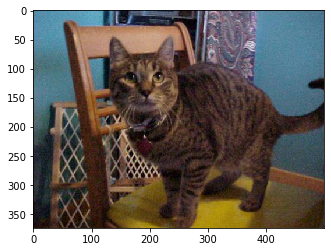

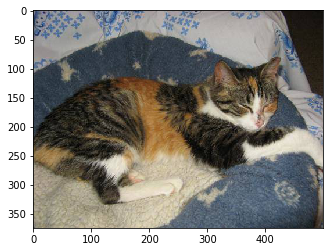

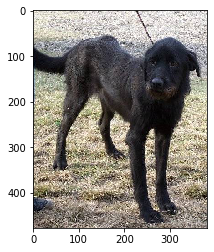

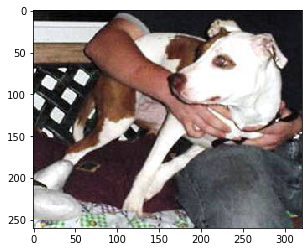

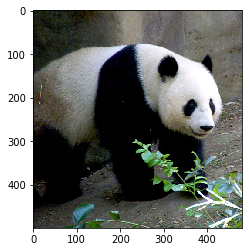

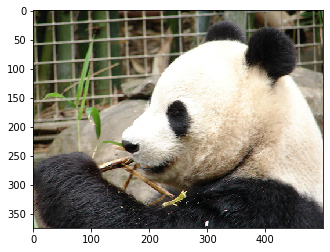

In [1259]:
animal_classes = list(df['label'].unique())

for classs in animal_classes:
    for i in range(2):
        img = plt.imread(df[df['label'] == classs].iloc[i,0])
        plt.imshow(img, interpolation='nearest')
        plt.show()


### Applying rotation augmentation

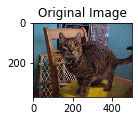

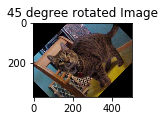

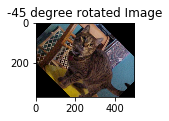

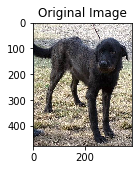

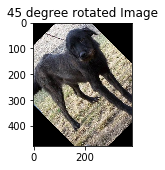

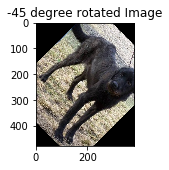

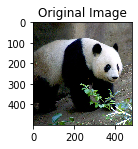

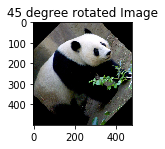

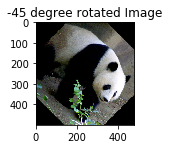

In [1260]:
for classs in animal_classes:
    img_data = plt.imread(df[df['label'] == classs].iloc[0,0])

    r_image = rotate(img_data, angle=45) # angle value is positive for anticlockwise rotation 
    r_image1 = rotate(img_data, angle=-45) # angle value is negative for clockwise rotation
    
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img_data, interpolation='nearest')
    plt.show()
    
    plt.subplot(1, 3, 2)
    plt.title('45 degree rotated Image')
    plt.imshow(r_image, interpolation='nearest')
    plt.show()

    plt.subplot(1, 3, 3)
    plt.title('-45 degree rotated Image')
    plt.imshow(r_image1, interpolation='nearest')
    plt.show()

### Applying height shift augmentation

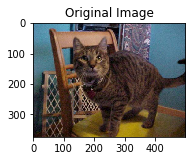

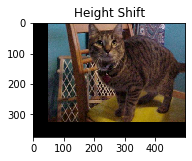

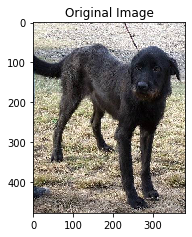

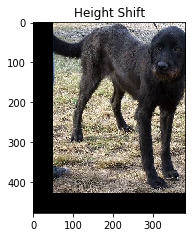

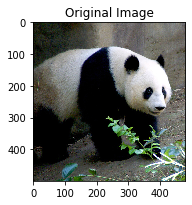

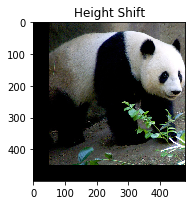

In [1261]:
for classs in animal_classes:
    img_data = plt.imread(df[df['label'] == classs].iloc[0,0])

    transform = AffineTransform(translation=(-50,50))  # (-200,0) are x and y coordinate, change it see the effect
    shifted_image = warp(img_data, transform) # mode parameter is optional
    
    plt.subplot(1,2,1)
    plt.title('Original Image')
    plt.imshow(img_data)
    plt.show()
    
    plt.subplot(1,2,2)
    plt.title('Height Shift')
    plt.imshow(shifted_image)
    plt.show()

### Bringing test and train data in the required shape for model training

In [1262]:
target_size = (108, 108, 3)
X = []
y = []
for index, row in df.iterrows():
    X.append(img_to_array(load_img(row['path'], target_size=target_size)))
    y.append(row['label'])


In [1263]:
X = np.array(X)
y = np.array(y)

In [1264]:
X = X/255 # normalization

In [1265]:
y = LabelEncoder().fit_transform(y)
y = to_categorical(y, num_classes=3)

In [1266]:
print(X.shape, y.shape)

(3000, 108, 108, 3) (3000, 3)


In [1267]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, shuffle=True, random_state=0)

print("Train Shape:")
print(X_train.shape, y_train.shape)

print("Test Shape:")
print(X_test.shape, y_test.shape)

Train Shape:
(2100, 108, 108, 3) (2100, 3)
Test Shape:
(900, 108, 108, 3) (900, 3)


In [1268]:
X_train = X_train.reshape(len(X_train), 108*108*3)
X_test = X_test.reshape(len(X_test), 108*108*3)

In [1269]:
X_train.shape, X_test.shape

((2100, 34992), (900, 34992))

### Training data shape - (2100, 34992) and test data shape - (900, 34992)

## Model Building

In [1270]:
model = Sequential()

# Input and hidden Layer 1
model.add(Dense(60, activation='relu', input_shape=(108*108*3, ), kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

# # Hidden Layer 2
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

# adding dropout
model.add(Dropout(0.5))

# Hidden Layer 3
model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))


# Output Layer
model.add(Dense(3, activation='softmax'))


In [1271]:
model.summary()

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_175 (Dense)            (None, 60)                2099580   
_________________________________________________________________
dense_176 (Dense)            (None, 50)                3050      
_________________________________________________________________
dropout_43 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_177 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_178 (Dense)            (None, 3)                 93        
Total params: 2,104,253
Trainable params: 2,104,253
Non-trainable params: 0
_________________________________________________________________


- Using sequential model layer with three hidden layers with L2 regularizers and dropout with value 0.5 added after the first hidden layer


- The values of neurons chosen is based on multiple iterations of model building where we observed that increasing the number of neurons or the hidden layers is not resulting in improved performance of the model.


- The value of dropout rate is chosen as standard with 0.5 and reducing or increasing the dropout which is added after the first hidden layer doesn't result in any performance improvement.


- The dropout was chosen after the second layer because that's where we were able to achieve decent accuracy with avoiding the overfitting problem


- L2 regularizers are used at every hidden layer as given in the problem statement and we have made use of three hidden layers as increasing the number of hidden layers is not resulting in increased performance due to the fact that the sample data size is not much and we could probably even get a good fit just by using one hidden layer

## Model Compilation

In [1272]:
opt = SGD(learning_rate=0.01, momentum=0.5)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

- Used SGD with learning rate 0.01 and momentum 0.5 as it seems the gradient is getting stuck in local minimas and not converging to an optimum solution

## Model Training

In [1273]:
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
start_time = time()
h = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=2100) #, callbacks=[callback])
training_time = time() - start_time

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 3.3515 - accuracy: 0.3143 - val_loss: 3.2415 - val_accuracy: 0.3452
Epoch 2/15
1/1 [==============================] - 0s 390ms/step - loss: 3.2428 - accuracy: 0.3548 - val_loss: 3.2282 - val_accuracy: 0.4048
Epoch 3/15
1/1 [==============================] - 0s 376ms/step - loss: 3.2345 - accuracy: 0.3827 - val_loss: 3.2270 - val_accuracy: 0.4310
Epoch 4/15
1/1 [==============================] - 0s 358ms/step - loss: 3.2278 - accuracy: 0.3946 - val_loss: 3.2231 - val_accuracy: 0.4071
Epoch 5/15
1/1 [==============================] - 0s 393ms/step - loss: 3.2252 - accuracy: 0.3548 - val_loss: 3.2148 - val_accuracy: 0.4905
Epoch 6/15
1/1 [==============================] - 0s 381ms/step - loss: 3.2205 - accuracy: 0.4256 - val_loss: 3.2133 - val_accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 0s 367ms/step - loss: 3.2176 - accuracy: 0.4256 - val_loss: 3.2098 - val_accuracy: 0.4714
Epoch 8/15
1/1 [=======

In [1274]:
md("<h3><b>Total time taken during model training - {} s</b>".format(round(training_time)))

<h3><b>Total time taken during model training - 8 s</b>

In [1275]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 3.202631950378418
Final training accuracy  0.4363095164299011


In [1276]:
print('Final validation loss \t', h.history['val_loss'][-1])
print('Final validation accuracy ', h.history['val_accuracy'][-1])

Final validation loss 	 3.1958696842193604
Final validation accuracy  0.4809523820877075


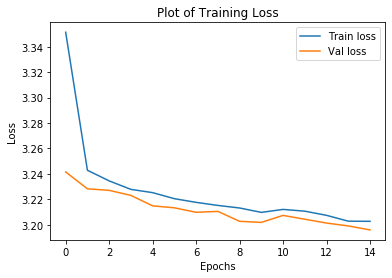

In [1277]:
# plot training and validation loss

plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['val_loss'], label='Val loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Training Loss')
plt.legend()
plt.show()

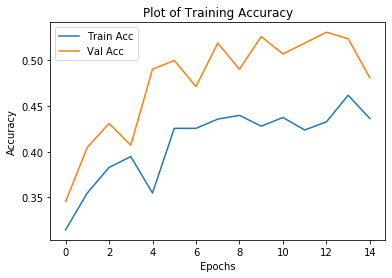

In [1278]:
# plot training and validation accuracy

plt.plot(h.history['accuracy'], label='Train Acc')
plt.plot(h.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot of Training Accuracy')
plt.legend()
plt.show()

## Model Evaluation

In [1279]:
loss, accuracy = model.evaluate(X_test, y_test)

29/29 [==============================] - 0s 10ms/step - loss: 3.2000 - accuracy: 0.4267


In [1280]:
print('Testing loss \t', loss)
print('Testing accuracy ', accuracy)

Testing loss 	 3.2000231742858887
Testing accuracy  0.4266666769981384


In [1281]:
predictions = model.predict(X_test)

In [1282]:
predictions = [np.argmax(i) for i in predictions]
rounded_y_test = [np.argmax(i) for i in y_test]

In [1283]:
cm = confusion_matrix(rounded_y_test, predictions)

In [1284]:
labels = ["cats", "dogs", "panda"]
df_cm = pd.DataFrame(cm, columns=labels, index=labels)

In [1285]:
df_cm

,cats,dogs,panda
cats,122,50,153
dogs,96,35,167
panda,31,19,227


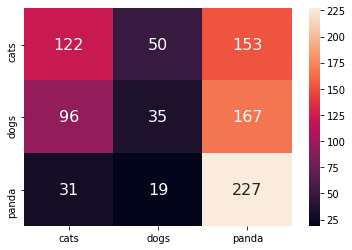

In [1286]:
import seaborn as sns

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [1287]:
print(classification_report(rounded_y_test, predictions, target_names=labels))

              precision    recall  f1-score   support

        cats       0.49      0.38      0.43       325
        dogs       0.34      0.12      0.17       298
       panda       0.41      0.82      0.55       277

    accuracy                           0.43       900
   macro avg       0.41      0.44      0.38       900
weighted avg       0.42      0.43      0.38       900



In [1288]:
performance_dict = {}
for idx, row in df_cm.iterrows():
    acc = int(row[idx])/(int(row[0]) + int(row[1]) + int(row[2]))
    performance_dict[idx] = acc
performance_dict

{'cats': 0.37538461538461537,
 'dogs': 0.1174496644295302,
 'panda': 0.8194945848375451}

In [1289]:
ordered_performance_dict = {k: v for k, v in sorted(performance_dict.items(), key=lambda item: item[1])}
print(f"Worst performing class - {list(ordered_performance_dict.keys())[0]}")
print(f"Best performing class - {list(ordered_performance_dict.keys())[2]}")

Worst performing class - dogs
Best performing class - panda


In [1290]:
errors = {}
for idx, val_pred in enumerate(predictions):
    if rounded_y_test[idx] != val_pred:
        errors[idx] = {'actual': rounded_y_test[idx], 'pred': val_pred}


### TODO: Print the two most incorrectly classified images of each class

# Hyperparameter Tuning

## - Creating a model without using regularization in the hidden layers

In [1291]:
model = Sequential()

# Input and hidden Layer 1
model.add(Dense(64, activation='relu', input_shape=(108*108*3, )))

# Hidden Layer 2
model.add(Dense(50, activation='relu'))
          
# Dropout
model.add(Dropout(0.5))

# Hidden Layer 3
model.add(Dense(30, activation='relu'))

# Output Layer
model.add(Dense(3, activation='softmax'))


In [1292]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_179 (Dense)            (None, 64)                2239552   
_________________________________________________________________
dense_180 (Dense)            (None, 50)                3250      
_________________________________________________________________
dropout_44 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_181 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_182 (Dense)            (None, 3)                 93        
Total params: 2,244,425
Trainable params: 2,244,425
Non-trainable params: 0
_________________________________________________________________


In [1293]:
opt = SGD(learning_rate=0.01, momentum=0.5)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [1294]:
start_time = time()
h = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=2100)
training_time = time() - start_time

Epoch 1/15
1/1 [==============================] - 2s 2s/step - loss: 1.1628 - accuracy: 0.3500 - val_loss: 1.1081 - val_accuracy: 0.2762
Epoch 2/15
1/1 [==============================] - 0s 311ms/step - loss: 1.1224 - accuracy: 0.3018 - val_loss: 1.0938 - val_accuracy: 0.3714
Epoch 3/15
1/1 [==============================] - 0s 340ms/step - loss: 1.1149 - accuracy: 0.3280 - val_loss: 1.0805 - val_accuracy: 0.4286
Epoch 4/15
1/1 [==============================] - 0s 317ms/step - loss: 1.0921 - accuracy: 0.3738 - val_loss: 1.0719 - val_accuracy: 0.4214
Epoch 5/15
1/1 [==============================] - 0s 343ms/step - loss: 1.0893 - accuracy: 0.3815 - val_loss: 1.0589 - val_accuracy: 0.4548
Epoch 6/15
1/1 [==============================] - 0s 342ms/step - loss: 1.0678 - accuracy: 0.4042 - val_loss: 1.0509 - val_accuracy: 0.5000
Epoch 7/15
1/1 [==============================] - 0s 354ms/step - loss: 1.0616 - accuracy: 0.4417 - val_loss: 1.0379 - val_accuracy: 0.4881
Epoch 8/15
1/1 [=======

In [1295]:
md("<h3><b>Total time taken during model training - {} s</b>".format(round(training_time)))

<h3><b>Total time taken during model training - 6 s</b>

In [1296]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 1.0295149087905884
Final training accuracy  0.46488094329833984


In [1297]:
print('Final validation loss \t', h.history['val_loss'][-1])
print('Final validation accuracy ', h.history['val_accuracy'][-1])

Final validation loss 	 0.961557924747467
Final validation accuracy  0.5523809790611267


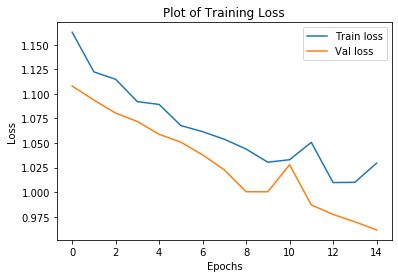

In [1298]:
# plot training and validation loss

plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['val_loss'], label='Val loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Training Loss')
plt.legend()
plt.show()

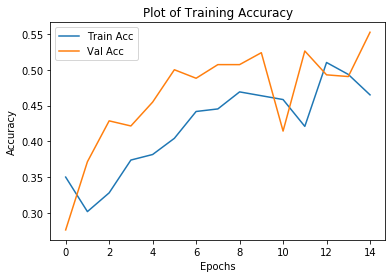

In [1299]:
# plot training and validation accuracy

plt.plot(h.history['accuracy'], label='Train Acc')
plt.plot(h.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot of Training Accuracy')
plt.legend()
plt.show()

In [1300]:
loss, accuracy = model.evaluate(X_test, y_test)

29/29 [==============================] - 0s 7ms/step - loss: 0.9988 - accuracy: 0.5222


In [1301]:
print('Testing loss \t', loss)
print('Testing accuracy ', accuracy)

Testing loss 	 0.9988126754760742
Testing accuracy  0.5222222208976746


In [1302]:
predictions = model.predict(X_test)

In [1303]:
predictions = [np.argmax(i) for i in predictions]
rounded_y_test = [np.argmax(i) for i in y_test]

In [1304]:
cm = confusion_matrix(rounded_y_test, predictions)

In [1305]:
labels = ["cats", "dogs", "panda"]
df_cm = pd.DataFrame(cm, columns=labels, index=labels)

In [1306]:
df_cm

,cats,dogs,panda
cats,144,83,98
dogs,95,106,97
panda,27,30,220


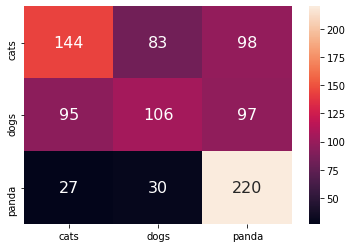

In [1307]:
import seaborn as sns

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [1308]:
print(classification_report(rounded_y_test, predictions, target_names=labels))

              precision    recall  f1-score   support

        cats       0.54      0.44      0.49       325
        dogs       0.48      0.36      0.41       298
       panda       0.53      0.79      0.64       277

    accuracy                           0.52       900
   macro avg       0.52      0.53      0.51       900
weighted avg       0.52      0.52      0.51       900



In [1309]:
performance_dict = {}
for idx, row in df_cm.iterrows():
    acc = int(row[idx])/(int(row[0]) + int(row[1]) + int(row[2]))
    performance_dict[idx] = acc
performance_dict

{'cats': 0.4430769230769231,
 'dogs': 0.35570469798657717,
 'panda': 0.7942238267148014}

In [1310]:
ordered_performance_dict = {k: v for k, v in sorted(performance_dict.items(), key=lambda item: item[1])}
print(f"Worst performing class - {list(ordered_performance_dict.keys())[0]}")
print(f"Best performing class - {list(ordered_performance_dict.keys())[2]}")

Worst performing class - dogs
Best performing class - panda


In [1311]:
errors = {}
for idx, val_pred in enumerate(predictions):
    if rounded_y_test[idx] != val_pred:
        errors[idx] = {'actual': rounded_y_test[idx], 'pred': val_pred}


In [1312]:
len(errors)

430

## - Creating a model by changing the dropout position

In [1313]:
model = Sequential()

# Input and hidden Layer 1
model.add(Dense(64, activation='relu', input_shape=(108*108*3, ), kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

# Hidden Layer 2
model.add(Dense(50, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

# Dropout
model.add(Dropout(0.5))

# Hidden Layer 3
model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l2(0.01)))

# Output Layer
model.add(Dense(3, activation='softmax'))


In [1314]:
model.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 64)                2239552   
_________________________________________________________________
dense_184 (Dense)            (None, 50)                3250      
_________________________________________________________________
dropout_45 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_185 (Dense)            (None, 30)                1530      
_________________________________________________________________
dense_186 (Dense)            (None, 3)                 93        
Total params: 2,244,425
Trainable params: 2,244,425
Non-trainable params: 0
_________________________________________________________________


In [1315]:
opt = SGD(learning_rate=0.01, momentum=0.5)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [1316]:
start_time = time()
h = model.fit(X_train, y_train, epochs=15, validation_split=0.2, batch_size=2100)
training_time = time() - start_time

Epoch 1/15
1/1 [==============================] - 3s 3s/step - loss: 3.8217 - accuracy: 0.3065 - val_loss: 3.3789 - val_accuracy: 0.3381
Epoch 2/15
1/1 [==============================] - 0s 375ms/step - loss: 3.3823 - accuracy: 0.3482 - val_loss: 3.3344 - val_accuracy: 0.3833
Epoch 3/15
1/1 [==============================] - 1s 659ms/step - loss: 3.3346 - accuracy: 0.3589 - val_loss: 3.3277 - val_accuracy: 0.4119
Epoch 4/15
1/1 [==============================] - 0s 447ms/step - loss: 3.3274 - accuracy: 0.3780 - val_loss: 3.3241 - val_accuracy: 0.3952
Epoch 5/15
1/1 [==============================] - 0s 398ms/step - loss: 3.3234 - accuracy: 0.4000 - val_loss: 3.3217 - val_accuracy: 0.3667
Epoch 6/15
1/1 [==============================] - 0s 385ms/step - loss: 3.3209 - accuracy: 0.3982 - val_loss: 3.3190 - val_accuracy: 0.3238
Epoch 7/15
1/1 [==============================] - 1s 570ms/step - loss: 3.3184 - accuracy: 0.3417 - val_loss: 3.3158 - val_accuracy: 0.3333
Epoch 8/15
1/1 [=======

In [1317]:
md("<h3><b>Total time taken during model training - {} s</b>".format(round(training_time)))

<h3><b>Total time taken during model training - 9 s</b>

In [1318]:
print('Final training loss \t', h.history['loss'][-1])
print('Final training accuracy ', h.history['accuracy'][-1])

Final training loss 	 3.294407844543457
Final training accuracy  0.38333332538604736


In [1319]:
print('Final validation loss \t', h.history['val_loss'][-1])
print('Final validation accuracy ', h.history['val_accuracy'][-1])

Final validation loss 	 3.2869622707366943
Final validation accuracy  0.4523809552192688


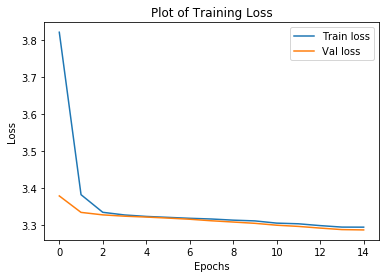

In [1320]:
# plot training and validation loss

plt.plot(h.history['loss'], label='Train loss')
plt.plot(h.history['val_loss'], label='Val loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Plot of Training Loss')
plt.legend()
plt.show()

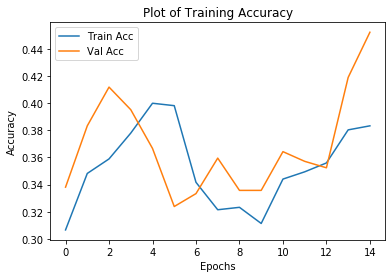

In [1321]:
# plot training and validation accuracy

plt.plot(h.history['accuracy'], label='Train Acc')
plt.plot(h.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot of Training Accuracy')
plt.legend()
plt.show()

In [1322]:
loss, accuracy = model.evaluate(X_test, y_test)

29/29 [==============================] - 0s 15ms/step - loss: 3.2918 - accuracy: 0.3844


In [1323]:
print('Testing loss \t', loss)
print('Testing accuracy ', accuracy)

Testing loss 	 3.2918004989624023
Testing accuracy  0.3844444453716278


In [1324]:
predictions = model.predict(X_test)

In [1325]:
predictions = [np.argmax(i) for i in predictions]
rounded_y_test = [np.argmax(i) for i in y_test]

In [1326]:
cm = confusion_matrix(rounded_y_test, predictions)

In [1327]:
labels = ["cats", "dogs", "panda"]
df_cm = pd.DataFrame(cm, columns=labels, index=labels)

In [1328]:
df_cm

,cats,dogs,panda
cats,10,121,194
dogs,6,91,201
panda,1,31,245


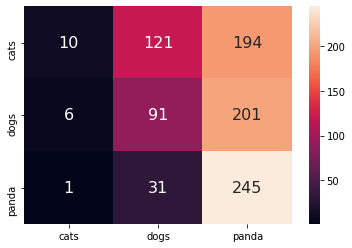

In [1329]:
import seaborn as sns

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g') # font size

plt.show()

In [1330]:
print(classification_report(rounded_y_test, predictions, target_names=labels))

              precision    recall  f1-score   support

        cats       0.59      0.03      0.06       325
        dogs       0.37      0.31      0.34       298
       panda       0.38      0.88      0.53       277

    accuracy                           0.38       900
   macro avg       0.45      0.41      0.31       900
weighted avg       0.45      0.38      0.30       900



In [1331]:
performance_dict = {}
for idx, row in df_cm.iterrows():
    acc = int(row[idx])/(int(row[0]) + int(row[1]) + int(row[2]))
    performance_dict[idx] = acc
performance_dict

{'cats': 0.03076923076923077,
 'dogs': 0.3053691275167785,
 'panda': 0.8844765342960289}

In [1332]:
ordered_performance_dict = {k: v for k, v in sorted(performance_dict.items(), key=lambda item: item[1])}
print(f"Worst performing class - {list(ordered_performance_dict.keys())[0]}")
print(f"Best performing class - {list(ordered_performance_dict.keys())[2]}")

Worst performing class - cats
Best performing class - panda


In [1333]:
errors = {}
for idx, val_pred in enumerate(predictions):
    if rounded_y_test[idx] != val_pred:
        errors[idx] = {'actual': rounded_y_test[idx], 'pred': val_pred}


In [1334]:
len(errors)

554

## Conclusion 

- Here we have built three models: 

 1. Model 1 - With L2 regularization in all the three hidden layers and dropout after the second hidden layer
 2. Model 2 - Without using any regularization and just using the droput after the second hidden layer
 3. Model 3 - With L2 regularization in all the three hidden layers but changing the position of the dropout to be used after the first hidden layer


- We observed that in models 1 and 3 where we have used regualarization along with dropout, the test and training accuracy are almost similar and we dont see any overfitting. Although the accuracy is just about 50% with Model 3 performing better than the rest two.

- Without using regularization we noticed an increasing in training accuracy but no improvement in terms of the test accuracy which indidcates that there is some level of overfitting which neeeds to be regularized.

- In all the three models, the accuracy is on the lower side even with multiple parameters used for tuning and increasing the number of iterations also did not result in higher accuracy. It seems that the gradient is getting stuck at a local minima which is no where close to the global minima and the model accuracy is not reaching beyond 60%

- Model 3 which uses no regularizers is surprsingly giving the best results out of the three models built in this notebook